# Task

#### Build a Convolutional Neural Network (CNN) model to classify images from a given dataset into predefined categories/classes.

## The Dataset

#### We could choose between Animals 10 and CIFAR-10; we chose the latter to focus on training our models.

#### - 60,000 32x32 color images in 10 classes
#### - 6,000 images per class.

## Imports

In [8]:
import os
import pickle
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation, RandomFlip, RandomTranslation, Lambda

## Setting the random seed

#### This will guarantee near-reproducible results.

#### TensorFlow is not bit-exact deterministic by default, so some tiny numerical differences can occur (~0.1 %-0.3 %). 

#### This can escalate exponentially, but the cost for determinism would be slowing down our training using the following import:

#### `from tensorflow.config.experimental import enable_op_determinism`

#### We decided not to use the import.

In [15]:
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Load CIFAR-10 dataset

In [16]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

## Data Exploration

#### Let's take a look at the shapes of our training and testing data. 

#### The second, third, and fourth columns of X will be our input format for the NN.

In [17]:
print('X_train: ' ,X_train.shape)
print('X_test: ' ,X_test.shape)
print('y_train: ' ,y_train.shape)
print('y_test: ' ,y_test.shape)

X_train:  (50000, 32, 32, 3)
X_test:  (10000, 32, 32, 3)
y_train:  (50000, 1)
y_test:  (10000, 1)


#### Also, it is good to define our classes as they are presented on the dataset homepage.

#### As we can see below, they are all perfectly balanced.

In [18]:
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [19]:
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(class_names[u], c)

airplane 5000
automobile 5000
bird 5000
cat 5000
deer 5000
dog 5000
frog 5000
horse 5000
ship 5000
truck 5000


### Check the min max pixel value

#### Just as a sanity check, let's see the min and max of the values, they should be 0 and 255

In [20]:
print("Min pixel value:", X_train.min())
print("Max pixel value:", X_train.max())

Min pixel value: 0
Max pixel value: 255


## Data Preprocessing 

#### Let's make our target y categorical and normalize our X by dividing its value by 255.

### OHE y to categorical 

In [21]:
num_classes = 10
y_train_ohe = to_categorical(y_train, num_classes)
y_test_ohe  = to_categorical(y_test,  num_classes)

In [22]:
print('y_train_ohe: ' ,y_train_ohe.shape)
print('y_test_ohe: ' ,y_test_ohe.shape)

y_train_ohe:  (50000, 10)
y_test_ohe:  (10000, 10)


### Normalize the training and test

In [23]:
X_train = X_train.astype('float32')/255.0

In [24]:
X_test = X_test.astype('float32')/255.0

#### As a sanity check let's see the mean and standard deviation.

In [25]:
mean_train = X_train.mean(axis=(0,1,2))
std_train  = X_train.std(axis=(0,1,2))

mean_test = X_test.mean(axis=(0,1,2))
std_test  = X_test.std(axis=(0,1,2))


print("Mean:", mean_train)
print("Std:", std_train)
print("Mean:", mean_test)
print("Std:", std_test)

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]
Mean: [0.49421427 0.4851322  0.45040992]
Std: [0.24665268 0.24289216 0.2615922 ]


In [83]:
challenger = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(32,32,3)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

challenger.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [26]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [85]:
challenger_history = challenger.fit(
    X_train, y_train_ohe,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.2978 - loss: 1.9229 - val_accuracy: 0.5228 - val_loss: 1.3554
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.4749 - loss: 1.4490 - val_accuracy: 0.5716 - val_loss: 1.2088
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.5288 - loss: 1.3086 - val_accuracy: 0.6126 - val_loss: 1.1211
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.5634 - loss: 1.2190 - val_accuracy: 0.6360 - val_loss: 1.0480
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.5924 - loss: 1.1456 - val_accuracy: 0.6562 - val_loss: 0.9991
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.6106 - loss: 1.0985 - val_accuracy: 0.6590 - val_loss: 0.9767
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.6192 - loss: 1.0583 - val_accuracy: 0.6606 - val_loss: 0.9721
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.6389 - loss: 1.0148 - 

#### We got 68 % as Test accuracy and 0.91 as test loss.

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6923 - loss: 0.8869
Test accuracy: 0.6866999864578247
Test loss: 0.9126209020614624


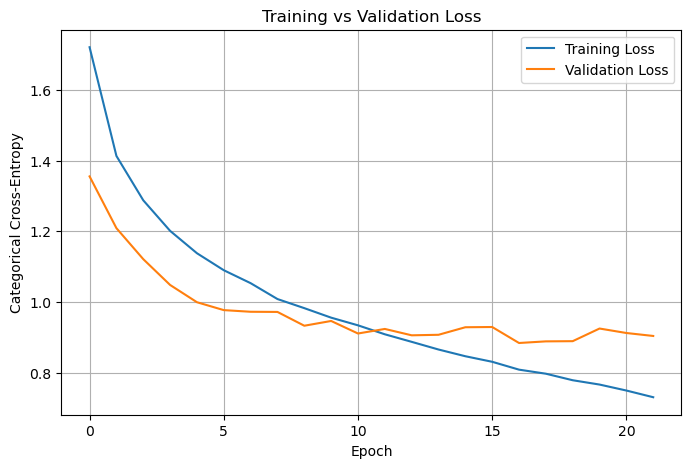

In [88]:
test_loss, test_acc = challenger.evaluate(X_test, y_test_ohe , verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

plt.figure(figsize=(8, 5))
plt.plot(challenger_history.history['loss'], label='Training Loss')
plt.plot(challenger_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross-Entropy')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
y_pred_proba = challenger.predict(X_test, batch_size=128, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


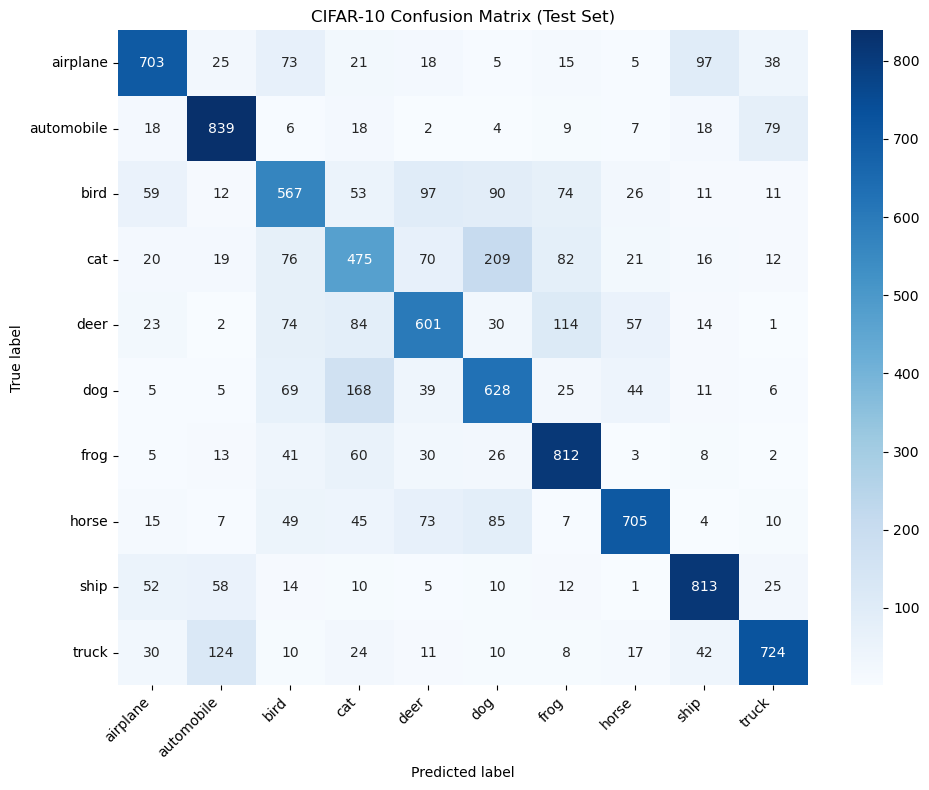

In [90]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CIFAR-10 Confusion Matrix (Test Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [93]:
# with open('challenger1.pkl', 'wb') as file:
#     pickle.dump(challenger, file)

In [101]:
challenger2 = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(32,32,3)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation="relu"),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

challenger2.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [102]:
challenger2_history = challenger2.fit(
    X_train, y_train_ohe,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.1756 - loss: 2.1255 - val_accuracy: 0.3542 - val_loss: 1.6817
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.3319 - loss: 1.7419 - val_accuracy: 0.4354 - val_loss: 1.5227
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.4163 - loss: 1.5761 - val_accuracy: 0.4746 - val_loss: 1.3991
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4656 - loss: 1.4550 - val_accuracy: 0.5170 - val_loss: 1.3204
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4957 - loss: 1.3806 - val_accuracy: 0.5310 - val_loss: 1.2535
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.5152 - loss: 1.3230 - val_accuracy: 0.5582 - val_loss: 1.1925
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.5432 - loss: 1.2679 - val_accuracy: 0.5900 - val_loss: 1.1330
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.5578 - loss: 1.2269 - 

In [104]:
challenger2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 10, 10, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,856 (616.63 KB)

 Trainable params: 52,618 (205.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,238 (411.09 KB)

#### We got 74 % as Test accuracy and 0.73 as test loss.

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.7494 - loss: 0.7274
Test accuracy: 0.7465999722480774
Test loss: 0.7314639091491699


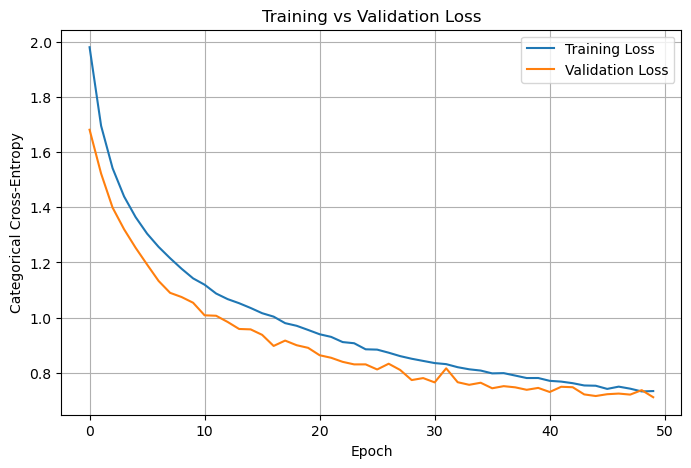

In [105]:
test_loss, test_acc = challenger2.evaluate(X_test, y_test_ohe , verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

plt.figure(figsize=(8, 5))
plt.plot(challenger2_history.history['loss'], label='Training Loss')
plt.plot(challenger2_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross-Entropy')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [106]:
y_pred_proba = challenger2.predict(X_test, batch_size=128, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step


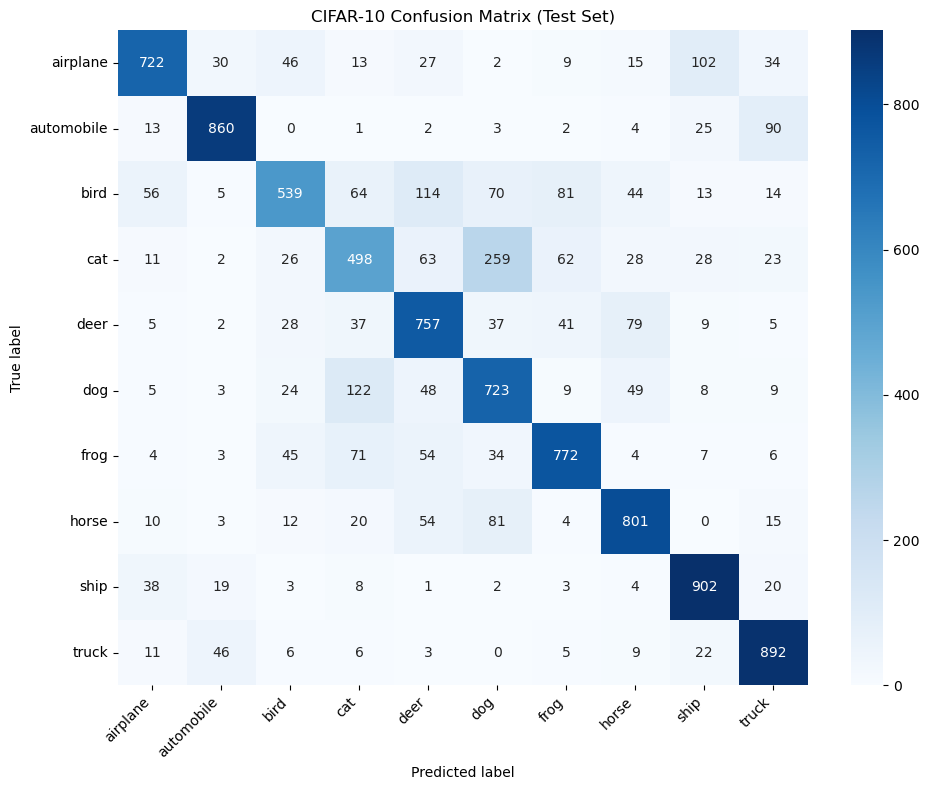

In [107]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CIFAR-10 Confusion Matrix (Test Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [109]:
# with open('challenger2.pkl', 'wb') as file:
#     pickle.dump(challenger2, file)

In [111]:
challenger3 = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(32,32,3)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), padding="same", activation="relu"),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

challenger3.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [112]:
challenger3_history = challenger3.fit(
    X_train, y_train_ohe,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 93s 242ms/step - accuracy: 0.1921 - loss: 2.1114 - val_accuracy: 0.3684 - val_loss: 1.6450
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 75s 214ms/step - accuracy: 0.3417 - loss: 1.7016 - val_accuracy: 0.4204 - val_loss: 1.5264
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 169ms/step - accuracy: 0.3991 - loss: 1.5764 - val_accuracy: 0.4628 - val_loss: 1.4438
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.4513 - loss: 1.4806 - val_accuracy: 0.5040 - val_loss: 1.3452
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - accuracy: 0.4869 - loss: 1.3940 - val_accuracy: 0.5344 - val_loss: 1.2905
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.5146 - loss: 1.3281 - val_accuracy: 0.5464 - val_loss: 1.2380
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 61s 171ms/step - accuracy: 0.5382 - loss: 1.2722 - val_accuracy: 0.5670 - val_loss: 1.1859
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 102s 289ms/step - accuracy: 0.5551 - loss: 

In [113]:
challenger3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,536 (881.00 KB)

 Trainable params: 75,178 (293.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 150,358 (587.34 KB)

#### We got 77 % as Test accuracy and 0.65 as test loss.

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7717 - loss: 0.6472
Test accuracy: 0.7748000025749207
Test loss: 0.6509679555892944


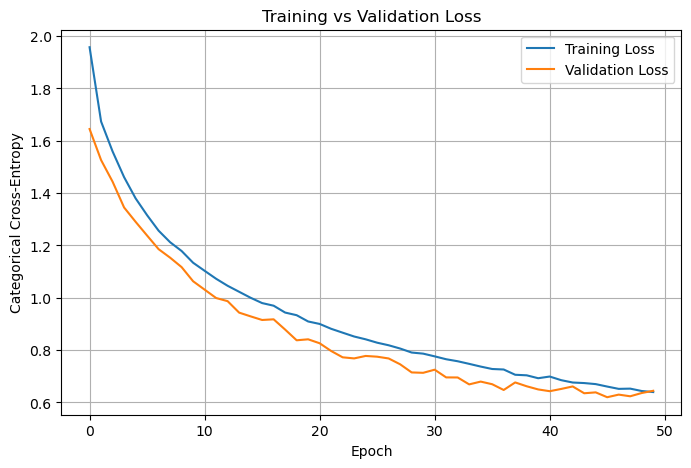

In [114]:
test_loss, test_acc = challenger3.evaluate(X_test, y_test_ohe , verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

plt.figure(figsize=(8, 5))
plt.plot(challenger3_history.history['loss'], label='Training Loss')
plt.plot(challenger3_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross-Entropy')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
y_pred_proba = challenger3.predict(X_test, batch_size=128, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


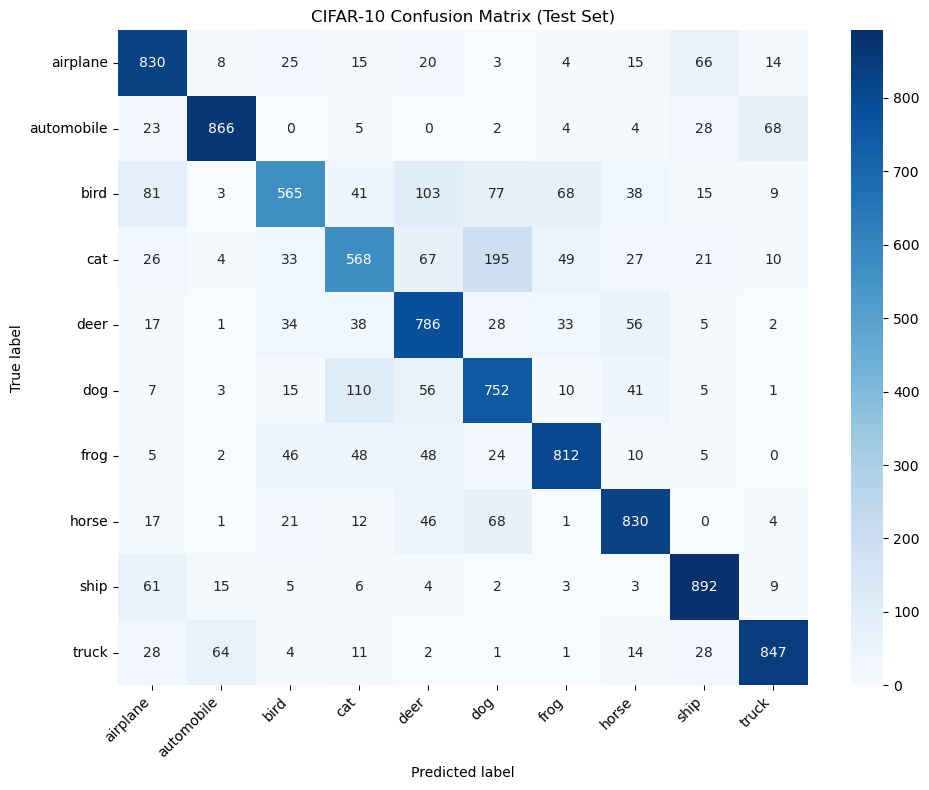

In [116]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CIFAR-10 Confusion Matrix (Test Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [120]:
# with open('challenger3.pkl', 'wb') as file:
#     pickle.dump(challenger3, file)

In [126]:
challenger4 = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(32,32,3)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), padding="same", activation="relu"),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

challenger4.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=3, name="top3_accuracy")]
)

In [128]:
challenger4_history = challenger4.fit(
    X_train, y_train_ohe,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 43s 90ms/step - accuracy: 0.1892 - loss: 2.1057 - top3_accuracy: 0.4879 - val_accuracy: 0.3736 - val_loss: 1.6480 - val_top3_accuracy: 0.7454
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.3511 - loss: 1.6891 - top3_accuracy: 0.7273 - val_accuracy: 0.4310 - val_loss: 1.5063 - val_top3_accuracy: 0.7960
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.4139 - loss: 1.5616 - top3_accuracy: 0.7728 - val_accuracy: 0.4766 - val_loss: 1.4156 - val_top3_accuracy: 0.8160
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.4537 - loss: 1.4733 - top3_accuracy: 0.7973 - val_accuracy: 0.5154 - val_loss: 1.3333 - val_top3_accuracy: 0.8320
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.4908 - loss: 1.3838 - top3_accuracy: 0.8260 - val_accuracy: 0.5272 - val_loss: 1.2945 - val_top3_accuracy: 0.8402
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.5197 - loss: 1.3210 - 

In [129]:
challenger4.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,536 (881.00 KB)

 Trainable params: 75,178 (293.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 150,358 (587.34 KB)

#### We got 77 % as Test accuracy and 0.66 as test loss.

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7715 - loss: 0.6599 - top3_accuracy: 0.9499
Test accuracy: 0.7692999839782715
Test loss: 0.6625622510910034


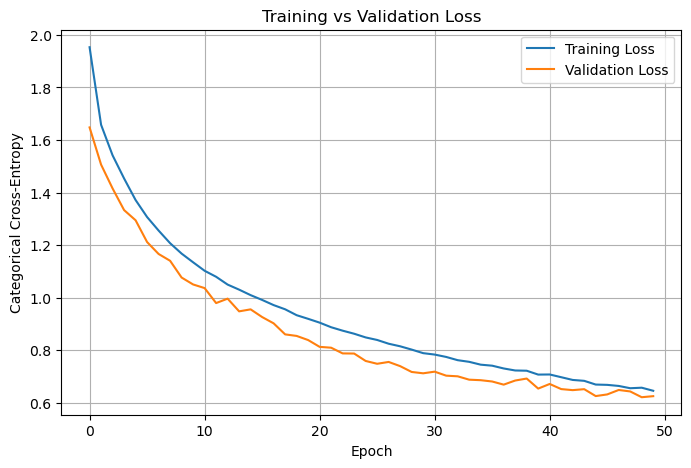

In [133]:
test_loss, test_acc, top3_accuracy = challenger4.evaluate(X_test, y_test_ohe , verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

plt.figure(figsize=(8, 5))
plt.plot(challenger4_history.history['loss'], label='Training Loss')
plt.plot(challenger4_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross-Entropy')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [134]:
y_pred_proba = challenger4.predict(X_test, batch_size=128, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step


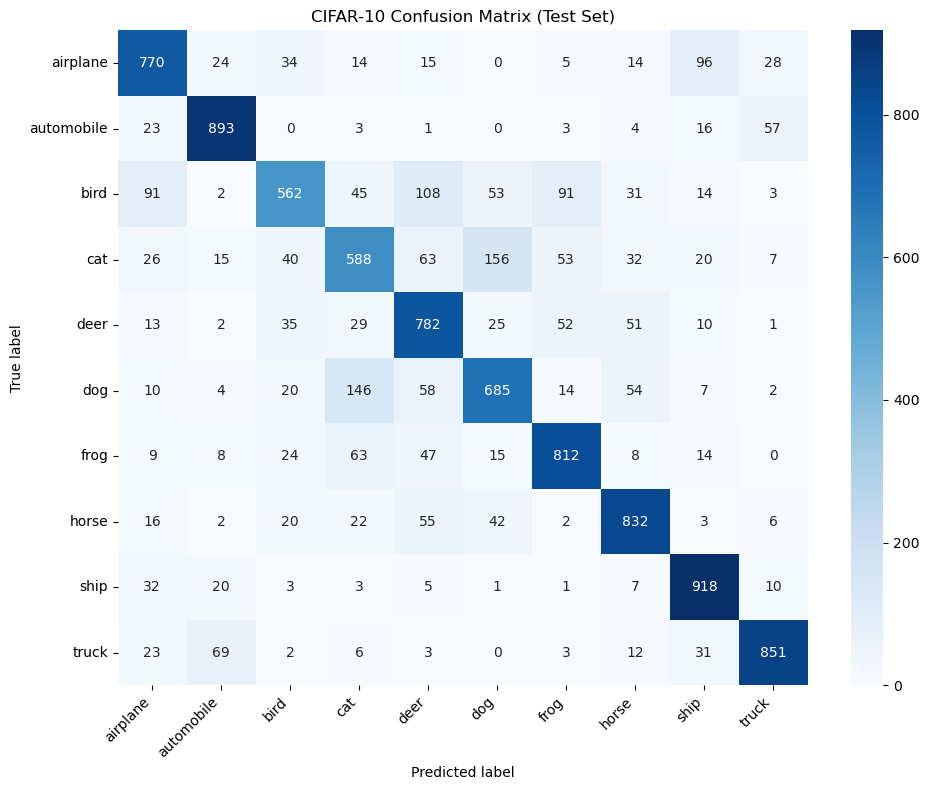

In [135]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CIFAR-10 Confusion Matrix (Test Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Challenger Model 5: 

#### Changed to SGD because it generalizes better than Adam

#### Changed the Learning Rate to 0.05, because our batch size is greater than 64.

#### Added momentum to 0.9 to be able to accelerate in consistent directions.

#### We also added nesterov=True to peek where momentum will take us.

#### We got 76 % as Test accuracy and 0.69 as test loss.

In [137]:
challenger5 = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(32,32,3)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), padding="same", activation="relu"),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

challenger5.compile(
    optimizer=SGD(learning_rate=0.05
                  ,momentum=0.9
                  ,nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=3, name="top3_accuracy")]
)

In [138]:
challenger5_history = challenger5.fit(
    X_train, y_train_ohe,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 39s 94ms/step - accuracy: 0.1087 - loss: 2.2988 - top3_accuracy: 0.3222 - val_accuracy: 0.1064 - val_loss: 2.3035 - val_top3_accuracy: 0.3010
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.1018 - loss: 2.3031 - top3_accuracy: 0.3033 - val_accuracy: 0.0996 - val_loss: 2.3018 - val_top3_accuracy: 0.3174
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.1111 - loss: 2.2989 - top3_accuracy: 0.3239 - val_accuracy: 0.1136 - val_loss: 2.2938 - val_top3_accuracy: 0.3620
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.1644 - loss: 2.2082 - top3_accuracy: 0.4249 - val_accuracy: 0.2254 - val_loss: 1.9969 - val_top3_accuracy: 0.5814
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.2341 - loss: 1.9679 - top3_accuracy: 0.5981 - val_accuracy: 0.3246 - val_loss: 1.7291 - val_top3_accuracy: 0.7100
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.3053 - loss: 1.7944 - 

In [143]:
challenger5.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 150,358 (587.34 KB)

 Trainable params: 75,178 (293.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 75,180 (293.68 KB)

#### We got 76 % as Test accuracy and 0.69 as test loss.

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7582 - loss: 0.6905 - top3_accuracy: 0.9472
Test accuracy: 0.7592999935150146
Test loss: 0.6966289281845093


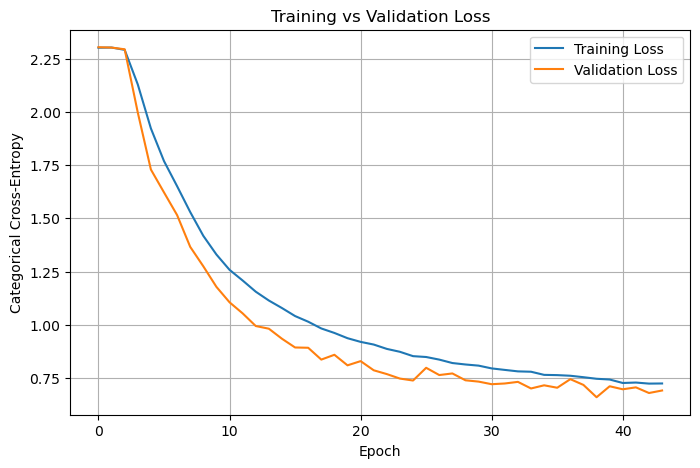

In [139]:
test_loss, test_acc, top3_accuracy = challenger5.evaluate(X_test, y_test_ohe , verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

plt.figure(figsize=(8, 5))
plt.plot(challenger5_history.history['loss'], label='Training Loss')
plt.plot(challenger5_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross-Entropy')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [140]:
y_pred_proba = challenger5.predict(X_test, batch_size=128, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


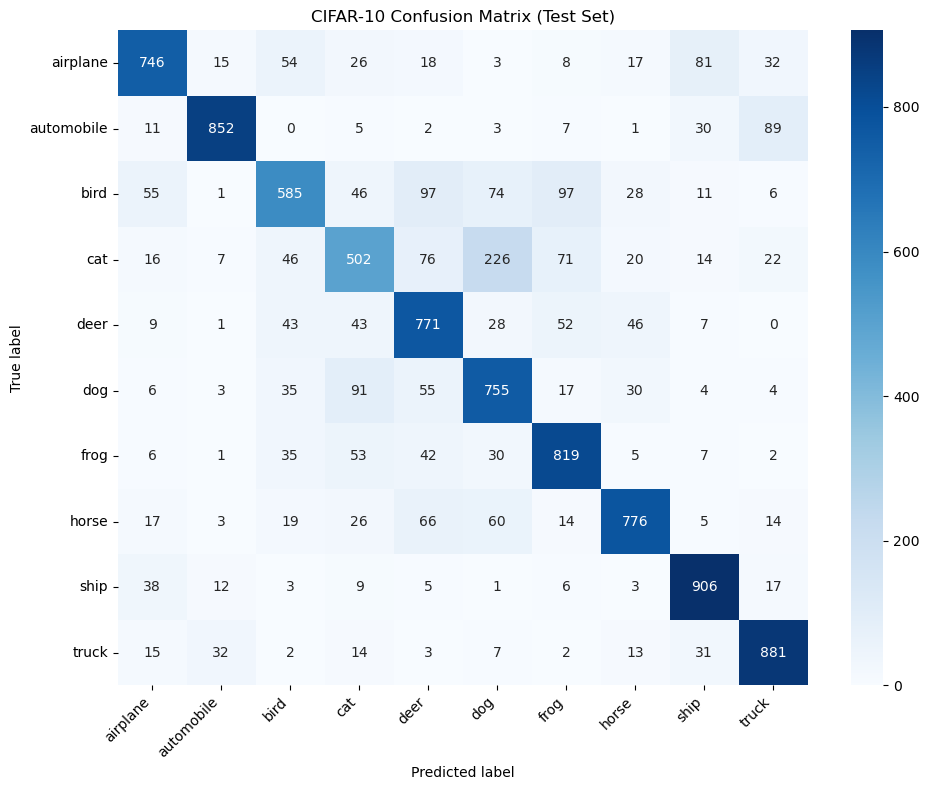

In [141]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CIFAR-10 Confusion Matrix (Test Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
challenger7 = Sequential([
    Conv2D(64, (3,3), padding="same", activation="relu", input_shape=(32,32,3)),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), padding="same", activation="relu"),
    Conv2D(128, (3,3), padding="same", activation="relu"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])


In [16]:
challenger7.compile(
    optimizer=SGD(learning_rate=0.05, momentum=0.9, nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=3, name="top3_accuracy")]
)

### Reduce Ron Plateau

In [27]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-4
)

In [18]:
history = challenger7.fit(
    X_train, y_train_ohe,
    validation_split=0.1,
    epochs=80,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 132s 363ms/step - accuracy: 0.1187 - loss: 2.2938 - top3_accuracy: 0.3343 - val_accuracy: 0.1078 - val_loss: 2.2961 - val_top3_accuracy: 0.3078 - learning_rate: 0.0500
Epoch 2/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 121s 345ms/step - accuracy: 0.1322 - loss: 2.2710 - top3_accuracy: 0.3631 - val_accuracy: 0.1582 - val_loss: 2.1755 - val_top3_accuracy: 0.4420 - learning_rate: 0.0500
Epoch 3/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 120s 342ms/step - accuracy: 0.2170 - loss: 2.0357 - top3_accuracy: 0.5631 - val_accuracy: 0.3018 - val_loss: 1.8320 - val_top3_accuracy: 0.6796 - learning_rate: 0.0500
Epoch 4/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 117s 331ms/step - accuracy: 0.2947 - loss: 1.8409 - top3_accuracy: 0.6676 - val_accuracy: 0.3476 - val_loss: 1.6782 - val_top3_accuracy: 0.7066 - learning_rate: 0.0500
Epoch 5/80
352/352 ━━━━━━━━━━━━━━━━━━━━ 115s 327ms/step - accuracy: 0.3702 - loss: 1.6780 - top3_accuracy: 0.7364 - val_accuracy: 0.4208 - val_loss: 1.5163 - val_top3_a

In [21]:
challenger7.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 555,926 (2.12 MB)

 Trainable params: 277,962 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 277,964 (1.06 MB)

#### We got 80 % as Test accuracy and 0.58 as test loss.

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.8069 - loss: 0.5856 - top3_accuracy: 0.9601
Test accuracy: 0.8058000206947327
Test loss: 0.5828078985214233
Test Top3 accuracy: 0.9589999914169312


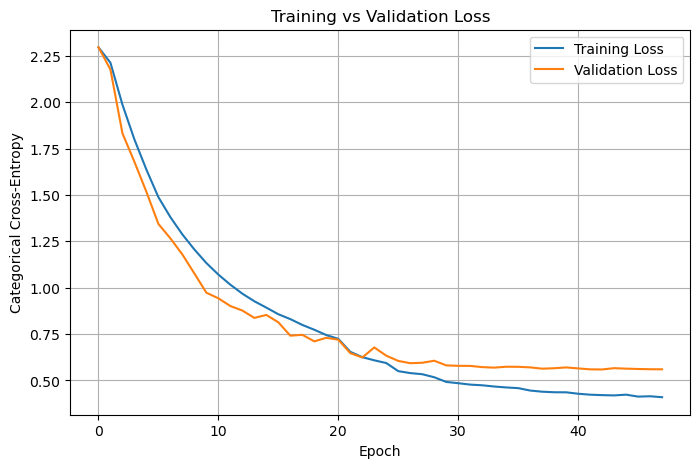

In [22]:
test_loss, test_acc, top3_accuracy = challenger7.evaluate(X_test, y_test_ohe , verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)
print("Test Top3 accuracy:", top3_accuracy)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross-Entropy')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
y_pred_proba = challenger7.predict(X_test, batch_size=128, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step


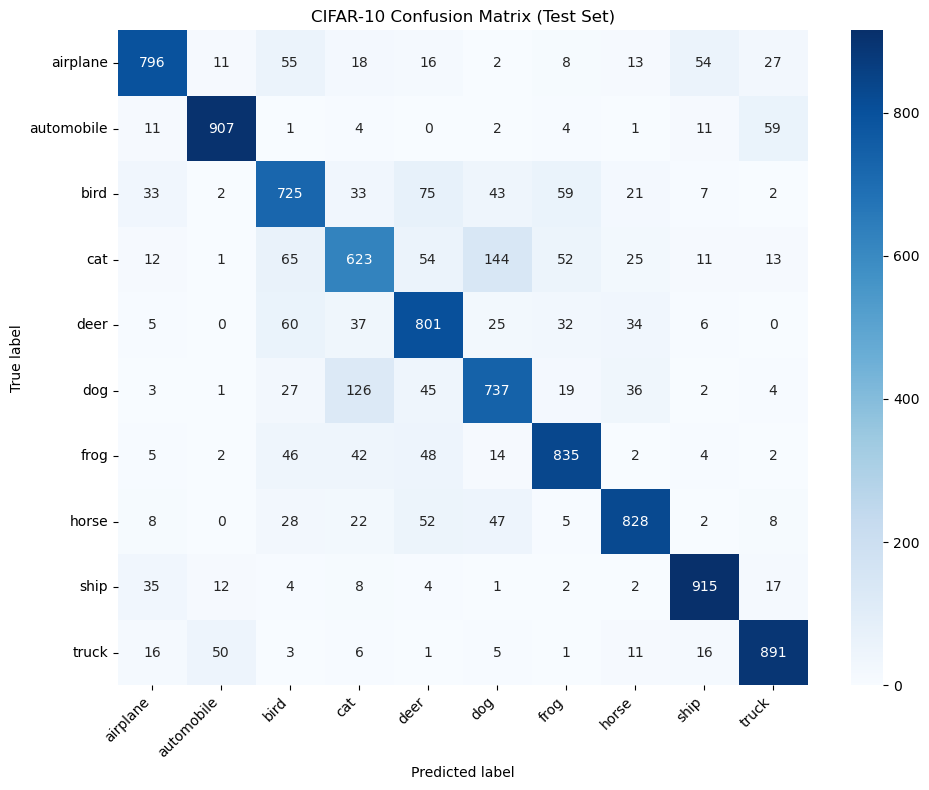

In [24]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CIFAR-10 Confusion Matrix (Test Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [25]:
with open('challenger7.pkl', 'wb') as file:
    pickle.dump(challenger7, file)

In [44]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train_ohe = to_categorical(y_train, 10)
y_test_ohe  = to_categorical(y_test, 10)

X_train_pp = preprocess_input(X_train.astype("float32"))
X_test_pp  = preprocess_input(X_test.astype("float32"))

In [63]:
vgg_transfer = VGG19(
    include_top=False,
    weights="imagenet",      
    input_shape=(32, 32, 3)
)

vgg_transfer.trainable = False

In [64]:
vgg_model = Sequential([ 
    RandomFlip("horizontal"),
    RandomTranslation(0.1, 0.1),
    
    Lambda(preprocess_input, name="vgg19_preprocess"),

    vgg_transfer,

    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(10, activation="softmax")    
])

vgg_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

vgg_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ ?                           │     0 (unbuilt) │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19_preprocess (Lambda)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [67]:
vgg_transfer.trainable = True   # Unfreezes

for layer in vgg_model.layers[:-4]:
    layer.trainable = False

vgg_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [101]:
p = Path("vgg_model.pkl")
data = p.read_bytes()


idx = data.find(b"PK\x03\x04")
print("ZIP header index:", idx)

if idx != -1:
    out = Path("recovered_model.keras")
    out.write_bytes(data[idx:])
    print("Wrote:", out, "size MB:", out.stat().st_size / (1024*1024))

    # Verify zip integrity
    with zipfile.ZipFile(out, "r") as z:
        print("Zip OK. First entries:", z.namelist()[:20])
else:
    print("No embedded zip header found inside the pickle.")

Files in archive (first 30): ['metadata.json', 'config.json', 'model.weights.h5']
Weight candidates: ['model.weights.h5']
Extracted weights file: model.weights.h5


In [ ]:
keras_zip = "recovered_model.keras"

with zipfile.ZipFile(keras_zip, "r") as z:
    names = z.namelist()
    print("Files in archive (first 30):", names[:30])

    weight_candidates = [n for n in names if n.endswith(".weights.h5") or "weights" in n.lower() and n.endswith(".h5")]
    print("Weight candidates:", weight_candidates)

    weights_name = weight_candidates[0]
    z.extract(weights_name, ".")

print("Extracted weights file:", weights_name)

In [102]:
vgg_transfer = VGG19(include_top=False
                     ,weights=None
                     ,input_shape=(32, 32, 3)
                    )

vgg_fixed = Sequential([
    RandomFlip("horizontal"),
    RandomTranslation(0.1, 0.1),

    # Lambda removed
    vgg_transfer,

    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(10, activation="softmax")
])

In [103]:
dummy = tf.zeros((1, 32, 32, 3), dtype=tf.float32)
_ = vgg_fixed(dummy, training=False)

vgg_fixed.load_weights(weights_name)

In [106]:
vgg_fixed.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [107]:
vgg_fixed.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (1, 32, 32, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (1, 32, 32, 3)              │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (1, 1, 1, 512)              │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (1, 512)                    │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 512)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 10)                     │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,029,514 (76.41 MB)

 Trainable params: 20,029,514 (76.41 MB)

 Non-trainable params: 0 (0.00 B)

##### We go test accuracy of 82 %, val loss 0.58.

In [109]:
x = preprocess_input(X_test.astype("float32"))

test_loss, test_acc = vgg_fixed.evaluate(x, y_test_ohe , verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 176ms/step - accuracy: 0.8315 - loss: 0.5661
Test accuracy: 0.8271999955177307
Test loss: 0.585747480392456


##### We could hyperparametrize more but we are good